# Experiment - Does Feature Store will load traning data faster than rerunning Feature Enigineering NB?



*   **Objective of the experiment:** Check does FEAST Featrue Store will load data faster than rerunning Feature Enigineering NB each time?
*   **Scenario:** Let's assume that Data Scientist - Mark created NB with Feature Engineering in order to create trainning data set. Prepared data looks good and he's ready to experiment with model, but it takes some time. Each day, he runs that NB to create features. Wouldn't it be better to push features into Feature Store?



### Preparing steps for experiment A:


*   Download raw data and repo with code
*   Installing requaired liblaries
*   Converting Feature_engineering NB to python script



In [ ]:
!git clone https://github.com/doxenix/feature-store-experiments.git

Cloning into 'airflow-test'...
remote: Enumerating objects: 86, done.
remote: Counting objects: 100% (86/86), done.
remote: Compressing objects: 100% (63/63), done.
remote: Total 86 (delta 18), reused 7 (delta 0), pack-reused 0
Unpacking objects: 100% (86/86), 35.02 KiB | 919.00 KiB/s, done.


In [ ]:
!pip install category_encoders==2.6.0 -q
!pip install feast==0.29 -q
!pip install typeguard==2.13.3 -q #workaround for feast v.0.29

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.2/81.2 KB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.8/29.8 MB 47.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 KB 12.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.1/57.1 KB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.5/71.5 KB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.8/57.8 KB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 73.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.4/29.4 MB 50.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.9/66.9 KB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.4/302.4 KB 26.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.6/69.6 KB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 191.6/191.6 KB 16.5 MB/s eta 0:0

In [ ]:
!jupyter nbconvert --to python airflow-test/Feature_engineering.ipynb

[NbConvertApp] Converting notebook airflow-test/Feature_engineering.ipynb to python
[NbConvertApp] Writing 11759 bytes to airflow-test/Feature_engineering.py


In [ ]:
# I'm using Google drive, but you can directly paste raw data into your own dir
# My dir: root = '/content/drive/MyDrive/data/'
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Run experiment A

Solution A - rerunning NB each day

In [ ]:
import time

def test_a_solution(script_path, n_times):

  test_a_results = []
  for _ in range(n_times):
    with open(script_path) as script:
        start_time = time.time()
        exec(script.read())
        result = time.time() - start_time
    test_a_results.append(result)

  return test_a_results

script_path = 'airflow-test/Feature_engineering.py'
n_times = 10

test_a_results = test_a_solution(script_path, n_times)

### Preparing steps for experiment B:


*   Generate dataset
*   Create needed files for FEAST
*   Apply FEAST repo

In [ ]:
!mkdir -p feature_repo
!mkdir -p feature_repo/data

We need append this code to existing Feature_engineering.py in order to generate dataset 

In [ ]:
%%writefile -a airflow-test/Feature_engineering.py

def random_dates(start, end, n):

    start_u = start.value//10**9
    end_u = end.value//10**9

    timestmap_df =  pd.to_datetime(np.random.randint(start_u, end_u, n), unit='s')
    
    return timestmap_df


start = pd.to_datetime('2022-01-01')
end = pd.to_datetime('2023-01-15')
df['event_timestamp'] = random_dates(start, end, df.shape[0])

df['transaction_id'] = df.index + 1

df.to_parquet('feature_repo/data/orders_data.parquet', index=False)
df[['transaction_id', 'event_timestamp']].to_parquet('entity_df.parquet', index=False)


Appending to airflow-test/Feature_engineering.py


In [ ]:
!python airflow-test/Feature_engineering.py

In [ ]:
%%writefile feature_repo/feature_store.yaml
project: default
registry: data/registry.db
provider: local
entity_key_serialization_version: 2

Writing feature_repo/feature_store.yaml


In [ ]:
%%writefile feature_repo/features.py
from datetime import timedelta

import pandas as pd

from feast import (
    Entity,
    FeatureService,
    FeatureView,
    Field,
    FileSource,
)

from feast.types import Float32, Float64, Int64, Int32
from feast import FileSource


transaction = Entity(name="transaction", join_keys=["transaction_id"])

transaction_source = FileSource(
    name="transaction_orders",
    path="/content/feature_repo/data/orders_data.parquet",
    event_timestamp_column="event_timestamp"
)

orders_fv = FeatureView(
    name="transaction_orders_fv",
    entities=[transaction],    
    schema=[
        Field(name="product_id", dtype=Int32),
        Field(name="total_product_orders_by_user", dtype=Float32),
        Field(name="total_product_reorders_by_user", dtype=Float32),
        Field(name="user_product_reorder_percentage", dtype=Float32),
        Field(name="avg_add_to_cart_by_user", dtype=Float32),
        Field(name="avg_days_since_last_bought", dtype=Float32),
        Field(name="last_ordered_in", dtype=Float32),
        Field(name="order_number", dtype=Float32),
        Field(name="order_dow", dtype=Float32),
        Field(name="order_hour_of_day", dtype=Float32),
        Field(name="days_since_prior_order", dtype=Float32),
        Field(name="reordered", dtype=Float32),
        Field(name="mean_add_to_cart_order", dtype=Float32),
        Field(name="total_orders", dtype=Int32),
        Field(name="total_reorders", dtype=Int32),
        Field(name="reorder_percentage", dtype=Float32),
        Field(name="unique_users", dtype=Int32),
        Field(name="order_first_time_total_cnt", dtype=Int32),
        Field(name="order_second_time_total_cnt", dtype=Int32),
        Field(name="is_organic", dtype=Int32),
        Field(name="second_time_percent", dtype=Float32),
        Field(name="aisle_mean_add_to_cart_order", dtype=Float32), 
        Field(name="aisle_std_add_to_cart_order", dtype=Float32),
        Field(name="aisle_total_orders", dtype=Int32),
        Field(name="aisle_total_reorders", dtype=Int32),
        Field(name="aisle_reorder_percentage", dtype=Float32),
        Field(name="aisle_unique_users", dtype=Int32),
        Field(name="aisle_0", dtype=Int32),
        Field(name="aisle_1", dtype=Int32),
        Field(name="aisle_2", dtype=Int32),
        Field(name="aisle_3", dtype=Int32),
        Field(name="aisle_4", dtype=Int32),
        Field(name="aisle_5", dtype=Int32),
        Field(name="aisle_6", dtype=Int32),
        Field(name="aisle_7", dtype=Int32),
        Field(name="department_mean_add_to_cart_order", dtype=Float32),
        Field(name="department_std_add_to_cart_order", dtype=Float32),
        Field(name="department_total_orders", dtype=Int32),
        Field(name="department_total_reorders", dtype=Int32),
        Field(name="department_reorder_percentage", dtype=Float32),
        Field(name="department_unique_users", dtype=Int32),
        Field(name="department_0", dtype=Int32),
        Field(name="department_1", dtype=Int32),
        Field(name="department_2", dtype=Int32),
        Field(name="department_3", dtype=Int32),
        Field(name="department_4", dtype=Int32),
        Field(name="avg_dow", dtype=Float32),
        Field(name="std_dow", dtype=Float32),
        Field(name="avg_doh", dtype=Float32),
        Field(name="std_doh", dtype=Int32),
        Field(name="avg_since_order", dtype=Float32),
        Field(name="std_since_order", dtype=Float32),
        Field(name="total_orders_by_user", dtype=Int32),
        Field(name="total_products_by_user", dtype=Int32),
        Field(name="total_unique_product_by_user", dtype=Int32),
        Field(name="total_reorders_by_user", dtype=Int32),
        Field(name="reorder_propotion_by_user", dtype=Float32),
        Field(name="average_order_size", dtype=Float32),
        Field(name="reorder_in_order", dtype=Float32),
        Field(name="orders_3", dtype=Int32),
        Field(name="orders_2", dtype=Int32),
        Field(name="orders_1", dtype=Int32),
        Field(name="reorder_3", dtype=Float32),
        Field(name="reorder_2", dtype=Float32),
        Field(name="reorder_1", dtype=Float32),  
        Field(name="user_id", dtype=Int32),
        Field(name="is_reorder_3", dtype=Int32),
        Field(name="is_reorder_2", dtype=Int32),
        Field(name="is_reorder_1", dtype=Int32)
    ],
    online=False,
    source=transaction_source,
)

transaction_stats_v1 = FeatureService(
    name="transaction_stats_v1",
    features=[orders_fv]
)


Writing feature_repo/features.py


In [ ]:
cd feature_repo

/content/feature_repo


In [ ]:
!feast apply

Feast is an open source project that collects anonymized error reporting and usage statistics. To opt out or learn more see https://docs.feast.dev/reference/usage
/usr/local/lib/python3.9/dist-packages/pkg_resources/__init__.py:121: DeprecationWarning: pkg_resources is deprecated as an API
  warnings.warn("pkg_resources is deprecated as an API", DeprecationWarning)
/usr/local/lib/python3.9/dist-packages/pkg_resources/__init__.py:2870: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('google')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
  declare_namespace(pkg)
/usr/local/lib/python3.9/dist-packages/pkg_resources/__init__.py:2870: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('google.cloud')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred 

### Run Experiment B

Solution B - Loading data from FEAST Feature Store

In [ ]:
import pandas as pd
from feast import FeatureStore
import time

def get_data_from_fs(entity_df_path, feature_service_name):
    store = FeatureStore(repo_path=".")
    feature_service = store.get_feature_service(feature_service_name)

    entity_df = pd.read_parquet(entity_df_path)

    offline_feature_data = store.get_historical_features(
        entity_df=entity_df,
        features=feature_service
    ).to_df()

    offline_feature_data.head()

    return offline_feature_data

def test_b_solution(entity_df_path, feature_service_name, n_times):

  test_b_results = []
  for _ in range(n_times):      
    start_time = time.time()
    get_data_from_fs(entity_df_path, feature_service_name)
    result = time.time() - start_time

    test_b_results.append(result)

  return test_b_results


entity_df_path = "/content/entity_df.parquet"
feature_service_name = "transaction_stats_v1"
n_times = 10

test_b_results = test_b_solution(entity_df_path, feature_service_name, n_times)

## Comparing results

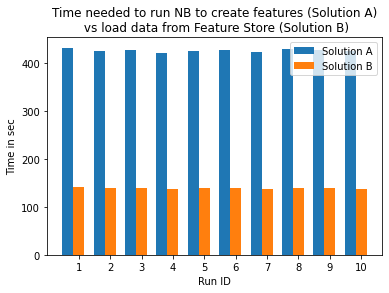

In [ ]:
import matplotlib.pyplot as plt

def compare_solutions(test_a_results, test_b_results):
  fig, ax = plt.subplots()
  bar_hight = 0.35
  indeks = range(len(test_a_results))
  ax.bar(indeks, test_a_results, bar_hight, label='Solution A')
  ax.bar([i + bar_hight for i in indeks], test_b_results, bar_hight, label='Solution B')

  ax.set_ylabel('Time in sec')
  ax.set_title('Time needed to run NB to create features (Solution A)\n vs load data from Feature Store (Solution B)')
  ax.set_xticks([i + bar_hight for i in indeks])
  ax.set_xticklabels([str(i+1) for i in range(len(test_a_results))])
  ax.set_xlabel('Run ID')
  ax.legend()

  plt.show()

compare_solutions(test_a_results, test_b_results)

In [ ]:
import pandas as pd
df = pd.read_parquet('/content/drive/MyDrive/data/orders_data.parquet')

In [ ]:
important_features = ['days_since_prior_order',                      
                      'total_product_orders_by_user',
                      'order_number',
                      'reorder_propotion_by_user',
                      'second_time_percent',
                      'total_unique_product_by_user',
                      'last_ordered_in',
                      'avg_since_order',
                      'reorder_percentage',
                      'average_order_size']

def save_df_with_important_features(features_list, df):
  columns = important_features + ['user_id', 'event_timestamp']
  df[columns].to_parquet('/content/drive/MyDrive/data/orders_data_10f.parquet', index=False)

save_df_with_important_features(important_features, df)

In [ ]:
df['user_id'].max()

206209

In [ ]:
df['event_timestamp'].min()

Timestamp('2022-01-01 00:00:35')

In [ ]:
df['event_timestamp'].max()

Timestamp('2023-01-14 23:59:48')

In [ ]:
df = df.head(1000000)
df.to_parquet('orders_data_light.parquet')

In [ ]:
df['user_id'].max()

24208

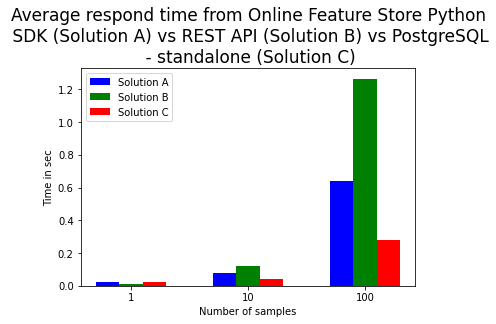

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def compare_solutions(test_a_results, test_b_results, test_c_results):
  X = np.arange(len(test_a_results))
  ax = plt.subplot(111)
  ax.bar(X-0.2, test_a_results.values(), width=0.2, color='b', align='center')
  ax.bar(X, test_b_results.values(), width=0.2, color='g', align='center')
  ax.bar(X+0.2, test_c_results.values(), width=0.2, color='r', align='center')
  ax.legend(('Solution A', 'Solution B','Solution C'))
  ax.set_ylabel('Time in sec')
  ax.set_xlabel('Number of samples')
  plt.xticks(X, test_a_results.keys())
  plt.title(
      "Average respond time from Online Feature Store Python\n SDK (Solution A) vs REST API (Solution B) vs PostgreSQL\n - standalone (Solution C)", 
      fontsize=17)  
  plt.show()

compare_solutions(a, b, c)  